# July 1, 2010

In this example we'll grab some data and plot records section

In [13]:
# imports
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, inventory
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

Set up the observation period.

In [2]:
# initialize an IRIS instance
client = Client('IRIS')

# set the start time
stime = UTCDateTime("2021-175T19:38:03")

# set the end time to be +10s
etime = stime + 10.

Get some data parameters.

In [3]:
# format is: Network, Location, Sensor, Band
# note that HHZ does not always exist, so check
sncls = [['IU', 'ANMO', '00', 'HHZ'], 
         ['IU', 'ANMO', '10', 'HHZ'],
         ['GS', 'ASA*', '00', 'HHZ']]

Collect the data into one stream and save the needed metadata.

In [4]:
# make an empty stream to store the results
stream = Stream()

# loop through the list of lists
for sncl in sncls:

    # check if the HHZ exists:
    try:
    
        # get the data streams (add some time padding -20s to account for filtering)
        stream += client.get_waveforms(sncl[0], sncl[1], sncl[2], sncl[3], stime-20., etime)
        
        # check if we have an inventory variable
        if 'inv' not in vars():
        
            # get some metadata from the inventory
            inventory = client.get_stations(network=sncl[0], station=sncl[1], 
                                           starttime=stime, endtime=etime, 
                                           level='response')
        
        # append if the variable already exists
        else:
            
            # get some metadata from the inventory
            inventory += client.get_stations(network=sncl[0], station=sncl[1], 
                                           starttime=stime, endtime=etime, 
                                           level='response')
    
    # print the error if we hit one
    except Exception as error:
        print("Oops!", error)

['IU', 'ANMO', '00', 'HHZ']
Oops! No data available for request.
Detailed response of server:


['IU', 'ANMO', '10', 'HHZ']
['GS', 'ASA*', '00', 'HHZ']


Check the results we just generated.

In [5]:
print(inventory)
print(stream)

Inventory created at 2021-07-01T17:00:35.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-06-24...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			GS
		Stations (6):
			GS.ASA1 (ASA1)
			GS.ASA2 (ASA2)
			GS.ASA3 (ASA3)
			GS.ASA4 (ASA4)
			GS.ASA5 (ASA5)
			GS.ASA6 (ASA6)
		Channels (54):
			GS.ASA1.00.HHZ, GS.ASA1.00.HH1, GS.ASA1.00.HH2, GS.ASA1.00.LHZ, 
			GS.ASA1.00.LH1, GS.ASA1.00.LH2, GS.ASA1.00.VM1, GS.ASA1.00.VM2, 
			GS.ASA1.00.VM3, GS.ASA2.00.HHZ, GS.ASA2.00.HH1, GS.ASA2.00.HH2, 
			GS.ASA2.00.LHZ, GS.ASA2.00.LH1, GS.ASA2.00.LH2, GS.ASA2.00.VM1, 
			GS.ASA2.00.VM2, GS.ASA2.00.VM3, GS.ASA3.00.HHZ, GS.ASA3.00.HH1, 
			GS.ASA3.00.HH2, GS.ASA3.00.LHZ, GS.ASA3.00.LH1, GS.ASA3.00.LH2, 
			GS.ASA3.00.VM1, GS.ASA3.00.VM2, GS.ASA3.00.VM3, GS.ASA4.00.HHZ, 
			GS.ASA4.00.HH1, GS.ASA4.00.HH2, GS.ASA4.00.LHZ, GS.ASA4.00.LH1, 
			GS.ASA4.00.LH2, GS.ASA4.00.VM1, GS.ASA4.00.VM2,

Calculate the distances to the earthquake

In [6]:
# add a fake earthquake location
eq_lat, eq_lon = 34.99, -106.52

# remove the problematic ANMO sites, note the station is not pre
stream = stream[2:]

# loop through each trace
for trace in stream:
    
    # get the coordinate dictionary
    locations = inventory.get_coordinates(trace.id, stime)
    
    # calculate the distances, first returned element is in meters
    trace.stats.distance = gps2dist_azimuth(locations['latitude'], locations['longitude'], 
                                                      eq_lat, eq_lon)[0]

GS.ASA2.00.HHZ
GS.ASA3.00.HHZ
GS.ASA4.00.HHZ
GS.ASA5.00.HHZ
GS.ASA6.00.HHZ


In [7]:
# filter our streams
stream.filter('bandpass', freqmin=1, freqmax=10)

# trim the extra off the beginning to avoid filter ringing
stream.trim(stime, etime)

5 Trace(s) in Stream:
GS.ASA2.00.HHZ | 2021-06-24T19:38:03.000000Z - 2021-06-24T19:38:13.000000Z | 100.0 Hz, 1001 samples
GS.ASA3.00.HHZ | 2021-06-24T19:38:03.000000Z - 2021-06-24T19:38:13.000000Z | 100.0 Hz, 1001 samples
GS.ASA4.00.HHZ | 2021-06-24T19:38:03.000000Z - 2021-06-24T19:38:13.000000Z | 100.0 Hz, 1001 samples
GS.ASA5.00.HHZ | 2021-06-24T19:38:03.000000Z - 2021-06-24T19:38:13.000000Z | 100.0 Hz, 1001 samples
GS.ASA6.00.HHZ | 2021-06-24T19:38:03.000000Z - 2021-06-24T19:38:13.000000Z | 100.0 Hz, 1001 samples

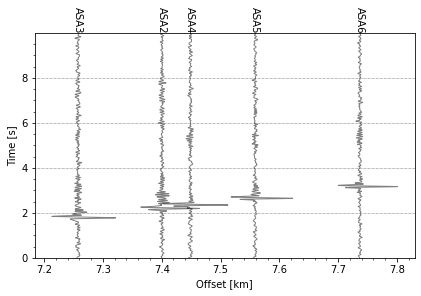

In [14]:
# show the figure
fig=plt.figure()
stream.plot(type='section', show='False', fig=fig)

# set the axis
ax = fig.axes[0]

# apply the mystery transform
transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)

# label each trace
for trace in stream:
    
    # add the text to the plot
    ax.text(trace.stats.distance/1e3, 1.0, 
            trace.stats.station, rotation=270, va='bottom', ha='center',
            transform=transform, zorder=10)

plt.show()